# Libraries Import

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image

In [2]:
# ---------------------------
# 1. Dataset Loading & Preprocessing
# ---------------------------
# We use an ImageFolder dataset for CIFAR-10 images stored in folders.
# For this project we filter to only include the "cat" and "dog" classes.
dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/train"
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # Normalize to [-1, 1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
# Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
# Get indices for only "cat" and "dog"
selected_classes = ['cat', 'dog']
selected_indices = [i for i, (path, label) in enumerate(full_dataset.samples)
                    if full_dataset.classes[label] in selected_classes]
dataset = Subset(full_dataset, selected_indices)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

test_dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/test"

# Use the same transform as for training.
test_full_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)

# Filter test dataset to include only "cat" and "dog" classes.
selected_classes = ['cat', 'dog']
test_selected_indices = [i for i, (path, label) in enumerate(test_full_dataset.samples)
                         if test_full_dataset.classes[label] in selected_classes]

test_dataset = Subset(test_full_dataset, test_selected_indices)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Test dataset loaded with {len(test_dataset)} samples.")

Using device: cuda
Test dataset loaded with 2000 samples.


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=150, feature_map_size=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: (latent_dim) x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            # State: (feature_map_size*8) x 4 x 4
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            # State: (feature_map_size*4) x 8 x 8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            # State: (feature_map_size*2) x 16 x 16
            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            # State: (feature_map_size) x 32 x 32
            nn.ConvTranspose2d(feature_map_size, 3, 3, 1, 1, bias=False),
            nn.Tanh()  # Output is in the range [-1, 1]
        )
    
    def forward(self, z):
        return self.net(z)

# Siamese Discriminator: Extract features from images and compute a similarity score.
class SiameseDiscriminator(nn.Module):
    def __init__(self, feature_map_size=64, alpha=1e-3):
        """
        alpha: scaling factor applied to the squared L2 norm.
        """
        super(SiameseDiscriminator, self).__init__()
        self.alpha = alpha
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, feature_map_size, 4, 2, 1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size*2, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(feature_map_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(feature_map_size*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, img1, img2):
        # Extract features for both images.
        f1 = self.feature_extractor(img1)
        f2 = self.feature_extractor(img2)
        # Flatten the features.
        f1 = f1.view(f1.size(0), -1)
        f2 = f2.view(f2.size(0), -1)
        # Compute the squared L2 norm difference.
        diff = f1 - f2
        dist_sq = torch.sum(diff * diff, dim=1, keepdim=True)
        # Scale the squared distance before the exponential.
        score = torch.exp(-self.alpha * dist_sq)
        return score

In [4]:
# ---------- 2.2 VAE Components -----------
class VAE(nn.Module):
    def __init__(self, latent_dim=512, feature_map_size=64):
        super(VAE, self).__init__()
        # Encoder: Input (3, 32, 32), output latent vector parameters
        self.encoder = nn.Sequential(
            nn.Conv2d(3, feature_map_size, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(feature_map_size, feature_map_size*2, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(feature_map_size*4),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.feature_dim = feature_map_size*4*4*4  # Final feature map flattened
        self.fc_mu = nn.Linear(self.feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_dim, latent_dim)
        
        # Decoder: Map latent vector to image
        self.fc_decode = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (feature_map_size*4, 4, 4)),
            nn.ConvTranspose2d(feature_map_size*4, feature_map_size*2, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size, 3, 4, 2, 1),
            nn.Tanh()  # Output in [-1,1]
        )
        
    def encode(self, x):
        x_enc = self.encoder(x)
        x_enc = self.flatten(x_enc)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [5]:
# ---------------------------
# 3. Loss Functions and Hyperparameters
# ---------------------------
# ----- For GAN using Minmax Loss (with similarity score) -----
epsilon = 1e-8  # To avoid log(0)
# For a given pair, D(x, y) is our similarity score as computed by SiameseDiscriminator.
# Define the minmax losses:
# For discriminator:

def ls_gan_discriminator_loss(D_real, D_fake):
    """
    Least-squares GAN loss for the discriminator.
    D_real should be close to 1 and D_fake close to 0.
    """
    loss_real = torch.mean((D_real - 1.0)**2)
    loss_fake = torch.mean(D_fake**2)
    return 0.5 * (loss_real + loss_fake)

def ls_gan_generator_loss(D_fake):
    """
    Least-squares GAN loss for the generator.
    The generator tries to have D_fake close to 1.
    """
    return 0.5 * torch.mean((D_fake - 1.0)**2)

In [6]:
# ----- For VAE: -----
# Use L1 loss (for sharper output) and KL divergence.
def vae_loss(recon, x, mu, logvar, kl_weight=0.01):
    recon_loss = nn.functional.l1_loss(recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

# Hyperparameters for GAN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gan_latent_dim = 150
lr_gen = 1e-4
lr_disc = 1e-4
beta1 = 0.5

# Hyperparameters for VAE
vae_latent_dim = 512      # High latent dimension to capture details
lr_vae = 5e-6             # Low learning rate for smooth optimization

In [7]:
# ---------------------------
# 4. Initialize Models and Optimizers
# ---------------------------
generator = Generator(latent_dim=gan_latent_dim).to(device)
discriminator = SiameseDiscriminator(alpha=1e-3).to(device)

optimizerG = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(beta1, 0.999))


# VAE Model
vae = VAE(latent_dim=vae_latent_dim).to(device)
optimizerVAE = optim.Adam(vae.parameters(), lr=lr_vae)

In [8]:
# ---------------------------
# 5. Training Loops
# ---------------------------
# ----- GAN Training Loop -----
# (Assume that your DataLoader named `dataloader` is already defined from your dataset.)

gan_loss_history = {"G": [], "D": []}
num_epochs = 400

print("Starting GAN Training...")

for epoch in range(1, num_epochs+1):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        
        # Generate fake images from random noise.
        noise = torch.randn(batch_size, gan_latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        
        # Compute discriminator outputs:
        # Use real pair (real, real) and fake pair (real, fake).
        D_real = discriminator(real_imgs, real_imgs)  # Desired output: 1
        D_fake = discriminator(real_imgs, fake_imgs)    # Desired output: 0
        
        # Update Discriminator.
        optimizerD.zero_grad()
        loss_D = ls_gan_discriminator_loss(D_real, D_fake)
        loss_D.backward()
        optimizerD.step()
        gan_loss_history["D"].append(loss_D.item())
        
        # Update Generator.
        optimizerG.zero_grad()
        noise = torch.randn(batch_size, gan_latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        D_fake = discriminator(real_imgs, fake_imgs)  # Generator wants D_fake to be close to 1.
        loss_G = ls_gan_generator_loss(D_fake)
        loss_G.backward()
        optimizerG.step()
        gan_loss_history["G"].append(loss_G.item())
        
        if i % 100 == 0:
            print(f"[GAN] Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")
    
    # Optionally, save sample outputs each epoch.
    sample_folder_gan = "gan_samples"
    os.makedirs(sample_folder_gan, exist_ok=True)
    with torch.no_grad():
        # Select 5 samples from the last batch to display.
        real_sample = real_imgs[:5]
        noise_sample = torch.randn(5, gan_latent_dim, 1, 1, device=device)
        fake_sample = generator(noise_sample)
        # Create a grid: show the 5 real images on one row and 5 generated images on the next row.
        grid = torchvision.utils.make_grid(torch.cat([real_sample, fake_sample], dim=0), nrow=5, normalize=True)
        save_image(grid, os.path.join(sample_folder_gan, f"epoch_{epoch}.png"))
    
print("GAN Training Completed.")

Starting GAN Training...
[GAN] Epoch [1/400] Batch [0/157] Loss_D: 0.0015 Loss_G: 0.4570
[GAN] Epoch [1/400] Batch [100/157] Loss_D: 0.0002 Loss_G: 0.4804
[GAN] Epoch [2/400] Batch [0/157] Loss_D: 0.0002 Loss_G: 0.4850
[GAN] Epoch [2/400] Batch [100/157] Loss_D: 0.0001 Loss_G: 0.4896
[GAN] Epoch [3/400] Batch [0/157] Loss_D: 0.0001 Loss_G: 0.4911
[GAN] Epoch [3/400] Batch [100/157] Loss_D: 0.0001 Loss_G: 0.4855
[GAN] Epoch [4/400] Batch [0/157] Loss_D: 0.0001 Loss_G: 0.4905
[GAN] Epoch [4/400] Batch [100/157] Loss_D: 0.0001 Loss_G: 0.4908
[GAN] Epoch [5/400] Batch [0/157] Loss_D: 0.0002 Loss_G: 0.4847
[GAN] Epoch [5/400] Batch [100/157] Loss_D: 0.0002 Loss_G: 0.4891
[GAN] Epoch [6/400] Batch [0/157] Loss_D: 0.0001 Loss_G: 0.4883
[GAN] Epoch [6/400] Batch [100/157] Loss_D: 0.0001 Loss_G: 0.4887
[GAN] Epoch [7/400] Batch [0/157] Loss_D: 0.0001 Loss_G: 0.4921
[GAN] Epoch [7/400] Batch [100/157] Loss_D: 0.0001 Loss_G: 0.4913
[GAN] Epoch [8/400] Batch [0/157] Loss_D: 0.0001 Loss_G: 0.4912
[

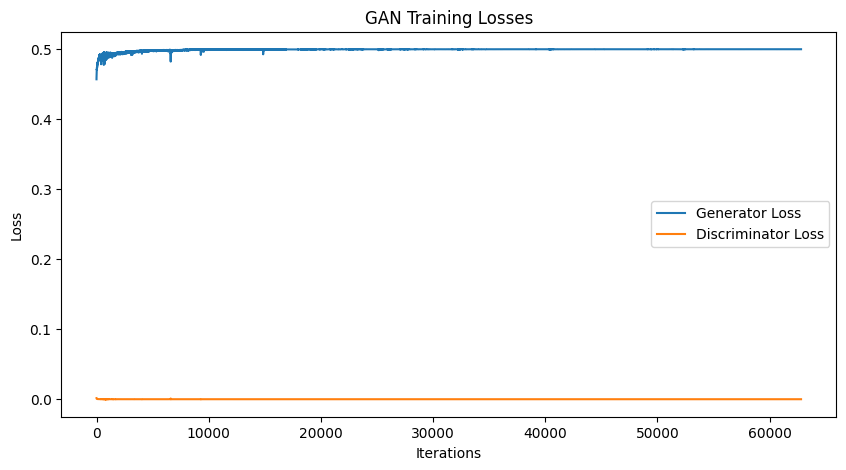

In [9]:
# Plot GAN Loss Curves
plt.figure(figsize=(10,5))
plt.plot(gan_loss_history["G"], label="Generator Loss")
plt.plot(gan_loss_history["D"], label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.show()

In [10]:
# ----- VAE Training Loop -----
vae_loss_history = {"total": [], "recon": [], "kl": []}
num_epochs_vae = 400  # set as needed

print("Starting VAE Training...")
vae.train()
for epoch in range(1, num_epochs_vae+1):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        optimizerVAE.zero_grad()
        recon, mu, logvar = vae(imgs)
        total_loss, recon_loss, kl_loss = vae_loss(recon, imgs, mu, logvar, kl_weight=0.01)
        total_loss.backward()
        optimizerVAE.step()
        
        vae_loss_history["total"].append(total_loss.item())
        vae_loss_history["recon"].append(recon_loss.item())
        vae_loss_history["kl"].append(kl_loss.item())
        
        if i % 100 == 0:
            print(f"[VAE] Epoch [{epoch}/{num_epochs_vae}] Batch [{i}/{len(dataloader)}] Loss: {total_loss.item():.4f} Recon: {recon_loss.item():.4f} KL: {kl_loss.item():.4f}")
    # Optionally save reconstructed samples per epoch
    sample_folder_vae = "vae_samples"
    os.makedirs(sample_folder_vae, exist_ok=True)
    with torch.no_grad():
        recon, _, _ = vae(imgs)
        # Denormalize from [-1, 1] to [0,1]
        imgs_denorm = (imgs + 1) / 2
        recon_denorm = (recon + 1) / 2
        # Build a grid: top row originals, bottom row reconstructions
        n = min(8, imgs.size(0))
        grid_orig = torchvision.utils.make_grid(imgs_denorm[:n], nrow=n)
        grid_recon = torchvision.utils.make_grid(recon_denorm[:n], nrow=n)
        combined = torch.cat([grid_orig, grid_recon], dim=1)
        save_image(combined, os.path.join(sample_folder_vae, f"epoch_{epoch}.png"))
        
print("VAE Training Completed.")

Starting VAE Training...
[VAE] Epoch [1/400] Batch [0/157] Loss: 124451.4141 Recon: 124409.7812 KL: 4163.1279
[VAE] Epoch [1/400] Batch [100/157] Loss: 115770.0078 Recon: 115694.8906 KL: 7511.7461
[VAE] Epoch [2/400] Batch [0/157] Loss: 106731.2031 Recon: 106577.5547 KL: 15364.9170
[VAE] Epoch [2/400] Batch [100/157] Loss: 91415.3359 Recon: 91029.6562 KL: 38567.6328
[VAE] Epoch [3/400] Batch [0/157] Loss: 84505.8984 Recon: 84006.4062 KL: 49949.3828
[VAE] Epoch [3/400] Batch [100/157] Loss: 81416.3359 Recon: 80908.4844 KL: 50784.9375
[VAE] Epoch [4/400] Batch [0/157] Loss: 74752.9375 Recon: 74295.0938 KL: 45784.3008
[VAE] Epoch [4/400] Batch [100/157] Loss: 68060.0078 Recon: 67546.4219 KL: 51358.5547
[VAE] Epoch [5/400] Batch [0/157] Loss: 66661.3750 Recon: 66146.4688 KL: 51491.0000
[VAE] Epoch [5/400] Batch [100/157] Loss: 62687.2852 Recon: 62130.2070 KL: 55707.9258
[VAE] Epoch [6/400] Batch [0/157] Loss: 61129.8047 Recon: 60559.7266 KL: 57007.7578
[VAE] Epoch [6/400] Batch [100/157] L

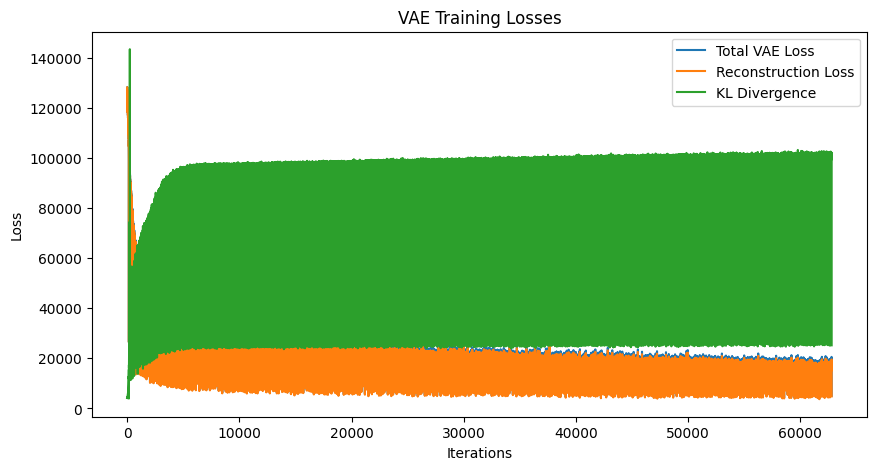

In [11]:
# Plot VAE Loss Curves
plt.figure(figsize=(10,5))
plt.plot(vae_loss_history["total"], label="Total VAE Loss")
plt.plot(vae_loss_history["recon"], label="Reconstruction Loss")
plt.plot(vae_loss_history["kl"], label="KL Divergence")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("VAE Training Losses")
plt.legend()
plt.show()

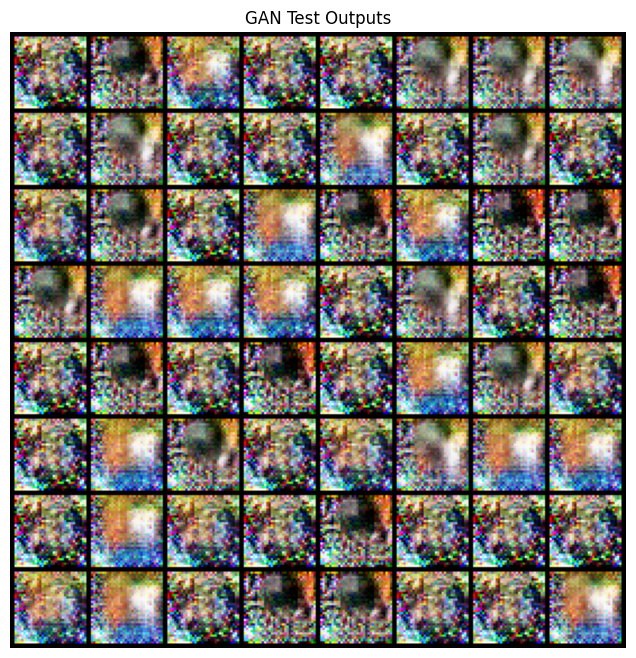

In [12]:
# ----- Testing GAN Outputs on Test Set -----
generator.eval()
with torch.no_grad():
    # Get a batch from the test loader.
    test_batch, _ = next(iter(test_dataloader))
    test_batch = test_batch.to(device)
    noise = torch.randn(test_batch.size(0), gan_latent_dim, 1, 1, device=device)
    fake_test = generator(noise)
    fake_test = (fake_test + 1) / 2  # Denormalize to [0,1]
    grid_test = make_grid(fake_test, nrow=8)
    
    plt.figure(figsize=(8,8))
    plt.title("GAN Test Outputs")
    plt.imshow(np.transpose(grid_test.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()
    save_image(fake_test, "gan_test_outputs.png", nrow=8, normalize=True)

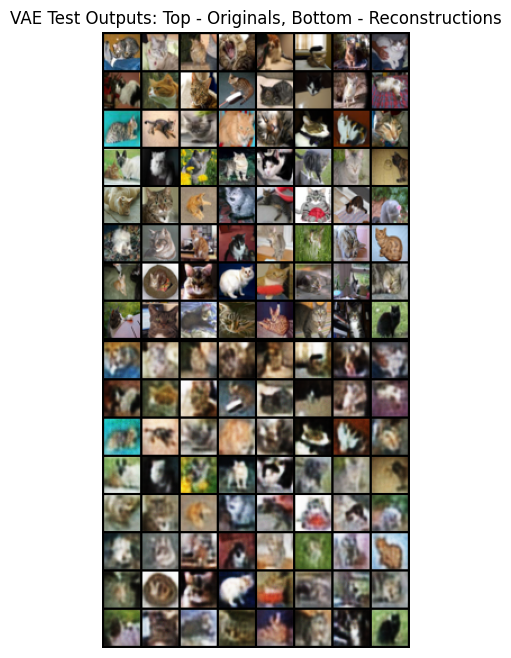

In [13]:
# ----- Testing VAE Outputs on Test Set -----
vae.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_dataloader))
    test_batch = test_batch.to(device)
    recon_test, _, _ = vae(test_batch)
    test_denorm = (test_batch + 1) / 2
    recon_denorm = (recon_test + 1) / 2
    grid_orig = make_grid(test_denorm, nrow=8)
    grid_recon = make_grid(recon_denorm, nrow=8)
    combined_test = torch.cat([grid_orig, grid_recon], dim=1)
    
    plt.figure(figsize=(16,8))
    plt.title("VAE Test Outputs: Top - Originals, Bottom - Reconstructions")
    plt.imshow(np.transpose(combined_test.cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()
    save_image(combined_test, "vae_test_outputs.png", normalize=True)